In [1]:
import pandas as pd
import geopandas
import contextily as cx
from fuzzywuzzy import fuzz
from collections import defaultdict
import matplotlib.pyplot as plt
from geopy import distance
from geopy.geocoders import Nominatim
import warnings
geolocator = Nominatim(user_agent="Maxwell_lee_Wood")

### Getting Taco Bell Location Data

In [2]:
ny_taco_df = pd.read_csv('taco_bell_new_york.csv')  
manhattan_taco_df = pd.read_csv('taco_bell_manhattan.csv')
brooklyn_taco_df = pd.read_csv('taco_bell_brooklyn.csv')
astoria_taco_df = pd.read_csv('taco_bell_astoria.csv')
bronx_taco_df = pd.read_csv('taco_bell_bronx.csv')
### Definintely missing some from queens but I think I'll start with just analyzing manhattan
taco_df = pd.concat([ny_taco_df,manhattan_taco_df,bronx_taco_df,brooklyn_taco_df,astoria_taco_df],ignore_index = True)


In [3]:
taco_locations = []
for index, row in taco_df.iterrows():
    x = geolocator.geocode(row.address+' '+row.city)
    taco_locations.append(x) 

In [4]:
##### its getting 1884 third Ave wrong so I'll have to fix it 
fixed = geolocator.geocode('1884 3rd Ave East Harlem')
taco_locations[22] = fixed

In [5]:
#### Strips useless info from dataframe
taco_df = taco_df.drop(columns = ['web-scraper-order','web-scraper-start-url','Links','Links-href'])

In [6]:
#### adds location to dataframe
taco_df['location'] = taco_locations
#### I also want to get rid of locations we werent able to find (so far they're just in the bronx)
taco_df = taco_df.dropna()

In [7]:
#### Get latitude and longitude from stations and adds them to the dataframe
taco_df['latitude'] = taco_df.location.apply(lambda x: x.latitude)
taco_df['longitude'] = taco_df.location.apply(lambda x: x.longitude)

In [8]:
### creating taco geo dataframe
geo_taco_df = geopandas.GeoDataFrame(
    taco_df,geometry=geopandas.points_from_xy(taco_df.longitude, taco_df.latitude))

### Getting Subway Location Data

In [9]:
Stations_df = pd.read_csv('Stations.csv')
#### This line concatenates the strings that make up the Routes so that 
#### it will match the MTA data
Stations_df['LINENAME']=Stations_df['Daytime Routes'].apply(lambda x: x.replace(' ',''))
#### I only care about location right now so I'm going to drop other stuff
Stations_df = Stations_df.rename(columns = {"Stop Name":"STATION","GTFS Latitude":"Latitude","GTFS Longitude":"Longitude"})
#### I'm going to rename the Station Names so that they match the MTA data
Stations_df.STATION= Stations_df.STATION.apply(lambda x: x.replace('th','').replace('rd','').replace('nd','').upper())
MTA_loc_df = Stations_df.copy()
MTA_loc_df = MTA_loc_df.drop(['Station ID','Complex ID','GTFS Stop ID','Structure','North Direction Label','South Direction Label','ADA','ADA Notes'], axis = 1)


In [10]:
#### Some manual cleaning to make the location and turnstile dataframes match

MTA_loc_df.STATION = MTA_loc_df.STATION.apply(lambda x: x
                                              .replace('PENN STATION','PENN STA')
                                              .replace('42 ST-PORT AUTHORITY BUS TERMINAL','42 ST-PORT AUTH')
                                              .replace('42 ST-PORT AUORITY BUS TERMINAL','42 ST-PORT AUTH'))
MTA_loc_df['STATION_LINENAME'] = MTA_loc_df.STATION+' '+MTA_loc_df.LINENAME

In [11]:
##### creating subway geo_location_data
geo_MTA_df = geopandas.GeoDataFrame(
    MTA_loc_df,geometry=geopandas.points_from_xy(MTA_loc_df.Longitude, MTA_loc_df.Latitude))

### Clipping and plotting Geopandas Data

In [12]:
#### Loading the new york burrows outline from geopandas datasets
nybb = geopandas.read_file(geopandas.datasets.get_path('nybb'))
### changing coordinate system to lat long
nybb = nybb.to_crs(epsg=4326)
#### Going to try to clip data only within manhattan so I'm only looking at subsets of
#### taco bells and subway stations that are within manhattan
manhattan_tacos = geopandas.clip(geo_taco_df,nybb[nybb.BoroName=='Manhattan'])
manhattan_MTA = geopandas.clip(geo_MTA_df,nybb[nybb.BoroName=='Manhattan'])
### Supressing warnings about manhattan's scale
warnings.filterwarnings('ignore')

/var/folders/vc/d1b_km4x7wb1xy8mb31ms7g00000gp/T/ipykernel_46780/2048076432.py:7: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  manhattan_tacos = geopandas.clip(geo_taco_df,nybb[nybb.BoroName=='Manhattan'])
/var/folders/vc/d1b_km4x7wb1xy8mb31ms7g00000gp/T/ipykernel_46780/2048076432.py:8: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  manhattan_MTA = geopandas.clip(geo_MTA_df,nybb[nybb.BoroName=='Manhattan'])


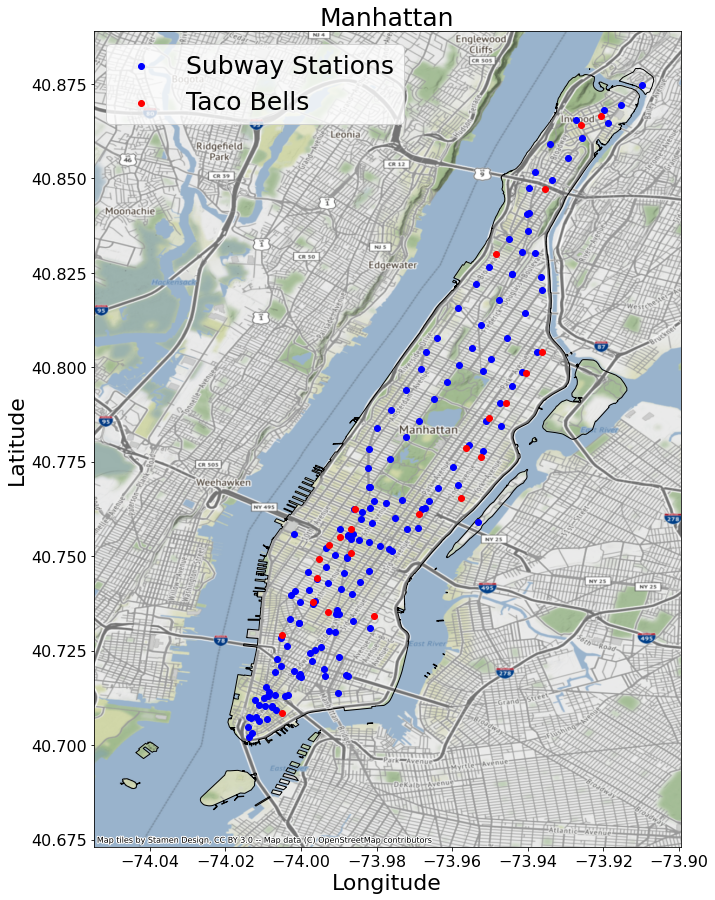

In [13]:
SMALL_SIZE = 16
MEDIUM_SIZE = 22
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
#plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
#plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
#plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


plt.rcParams["figure.figsize"]=15,15

#### Only looking at Manhattan

ax = nybb[nybb.BoroName=='Manhattan'].plot(
   color='None', edgecolor='black')

#### Manhattan MTA
manhattan_MTA.plot(ax = ax, color ='blue',label = 'Subway Stations',alpha = 1)
#### Manhattan Tacos
manhattan_tacos.plot(ax = ax, color ='red',label = 'Taco Bells', alpha = 1)
cx.add_basemap(ax, crs=nybb.crs)#,source=cx.providers.CartoDB.Positron)

#### All of new york
#axx = nybb.plot(color='None', edgecolor='black')

# Plotting Subway Stations:
#geo_MTA_df.plot(ax = axx, color ='blue',label = 'Subway Stations')

# Plotting Taco Bell Data LIVE MAS!
#geo_taco_df.plot(ax = axx, color ='red',label = 'Taco Bells')

#cx.add_basemap(axx, crs=nybb.crs)#,source=cx.providers.CartoDB.Positron)

plt.legend(loc="upper left")
plt.title("Manhattan")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


In [14]:
#### Think about manhattan distance
#### This forloop calculates the distances each taco bell is from all the subway station
#### and returns subways that are less than .26 miles away
taco_subway_pairs = []
relevant_stations = []
for i,x in manhattan_tacos.iterrows():
    nearby_subways = []
    for j,y in manhattan_MTA.iterrows():
        p1 = (x.latitude,x.longitude)
        p2 = (y.Latitude,y.Longitude)
        z = distance.distance(p1,p2).miles
        if  z <= 0.26:
            nearby_subways.append([y.STATION,y.LINENAME, z])
            #relevant_stations.append(y.STATION+' '+y.LINENAME)
            relevant_stations.append(y.STATION_LINENAME)
    taco_subway_pairs.append([x.address,nearby_subways])
    del nearby_subways

In [15]:
#### This is just dropping duplicates from the list and sorting it
station_set = sorted(list(set(relevant_stations)))

### Getting Data with SQL (Not currently Used)

In [16]:
import sqlalchemy as db
engine = db.create_engine("sqlite:///mta_data.db")
sql_df = pd.read_sql('SELECT * FROM mta_data;',engine)
sql_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,03:00:00,REGULAR,7672966,2645023
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,07:00:00,REGULAR,7672969,2645040
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,11:00:00,REGULAR,7672991,2645127
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,15:00:00,REGULAR,7673037,2645193
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,19:00:00,REGULAR,7673097,2645270


### Importing Data with Website ( I did this prior to knowing sqlalchemy was a thing)

In [17]:
from datetime import datetime, date, timedelta
import datetime
#### Making a list of dates that mta's website will read
#### Right now I'm getting all the data from 2021
#### It was probably easier to just use SQLite
first_day = date(2021,1,2)
week = timedelta(days = 7)
week_numbers = []
current_day = first_day
while current_day.year<2022:
    if current_day.month<10:
        qqq = '0'
    if current_day.month>=10:
        qqq = ''
    if current_day.day<10:
        ggg = '0'
    if current_day.day>=10:
        ggg = ''
    day_string = '21'+qqq+str(current_day.month)+ggg+str(current_day.day)
    week_numbers.append(day_string)
    current_day = current_day+week


In [18]:
# Source: http://web.mta.info/developers/turnstile.html
def get_data(week_nums):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url))
    return pd.concat(dfs)
        
week_nums = week_numbers
turnstiles_df = get_data(week_nums)

### Cleaning Data

####  aka Shamelessly Copying Homework Solutions to clean the turnstile data

In [19]:
##### Getting rid of all the spaces after exit
turnstiles_df.columns = [column.strip() for column in turnstiles_df.columns]

In [20]:
# One Year of Data
#turnstiles_df.DATE.value_counts().sort_index()

In [21]:
# Take the date and time fields into a single datetime column
turnstiles_df["DATE_TIME"] = pd.to_datetime(turnstiles_df.DATE + " " + turnstiles_df.TIME, 
                                            format="%m/%d/%Y %H:%M:%S")

In [22]:
# Get rid of the duplicate entry
turnstiles_df.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], 
                          inplace=True, ascending=False)
turnstiles_df.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True)

In [23]:
# Drop Exits and Desc Column.  To prevent errors in multiple run of cell, errors on drop is ignored
turnstiles_df_ent = turnstiles_df.drop([ "EXITS","DESC"], axis=1, errors="ignore")
turnstiles_df_ext = turnstiles_df.drop([ "ENTRIES","DESC"], axis=1, errors="ignore")


In [24]:
#### Creating a unique identifier for each station name
turnstiles_df_ent["STATION_LINENAME"] = turnstiles_df_ent.STATION+' '+turnstiles_df_ent.LINENAME
turnstiles_df_ext["STATION_LINENAME"] = turnstiles_df_ext.STATION+' '+turnstiles_df_ext.LINENAME

In [25]:
turnstiles_daily_ent = (turnstiles_df_ent
                        .groupby(["C/A", "UNIT", "SCP", "STATION_LINENAME", "DATE","STATION"],as_index=False)
                        .ENTRIES.first())
turnstiles_daily_ext = (turnstiles_df_ext
                        .groupby(["C/A", "UNIT", "SCP", "STATION_LINENAME", "DATE","STATION"],as_index=False)
                        .EXITS.first())

In [26]:
turnstiles_daily_ent[["PREV_DATE", "PREV_ENTRIES"]] = (turnstiles_daily_ent
                                                       .groupby(["C/A", "UNIT", "SCP", "STATION_LINENAME"])["DATE", "ENTRIES"]
                                                       .apply(lambda grp: grp.shift(1)))
turnstiles_daily_ext[["PREV_DATE", "PREV_EXITS"]] = (turnstiles_daily_ext
                                                       .groupby(["C/A", "UNIT", "SCP", "STATION_LINENAME"])["DATE", "EXITS"]
                                                       .apply(lambda grp: grp.shift(1)))

In [27]:
# Drop the rows for the earliest date in the df
turnstiles_daily_ext.dropna(subset=["PREV_DATE"], axis=0, inplace=True)
turnstiles_daily_ent.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

In [28]:
def get_daily_counts_ent(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        ###No printing!
        #print(row["ENTRIES"], row["PREV_ENTRIES"])
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter
# If counter is > 1Million, then the counter might have been reset.  
# Just set it to zero as different counters have different cycle limits
# It'd probably be a good idea to use a number even significantly smaller than 1 million as the limit!
turnstiles_daily_ent["DAILY_ENTRIES"] = turnstiles_daily_ent.apply(get_daily_counts_ent, axis=1, max_counter=1000000)

def get_daily_counts_ext(row, max_counter):
    counter = row["EXITS"] - row["PREV_EXITS"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        #### don't want printing
        #print(row["EXITS"], row["PREV_EXITS"])
        counter = min(row["EXITS"], row["PREV_EXITS"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter

# If counter is > 1Million, then the counter might have been reset.  
# Just set it to zero as different counters have different cycle limits
# It'd probably be a good idea to use a number even significantly smaller than 1 million as the limit!
turnstiles_daily_ext["DAILY_EXITS"] = turnstiles_daily_ext.apply(get_daily_counts_ext, axis=1, max_counter=1000000)

In [29]:
station_daily_ent = turnstiles_daily_ent.groupby(["STATION_LINENAME", "DATE", 'STATION'])[['DAILY_ENTRIES']].sum().reset_index()
station_daily_ext = turnstiles_daily_ext.groupby(["STATION_LINENAME", "DATE", 'STATION'])[['DAILY_EXITS']].sum().reset_index()

In [30]:
station_totals_ent = station_daily_ent.groupby(['STATION_LINENAME','STATION']).sum()\
    .sort_values('DAILY_ENTRIES', ascending=False)\
    .reset_index()
station_totals_ent = station_totals_ent.rename(columns = {'DAILY_ENTRIES':'YEARLY_ENTRIES'})

station_totals_ext = station_daily_ext.groupby(['STATION_LINENAME','STATION']).sum()\
    .sort_values('DAILY_EXITS', ascending=False)\
    .reset_index()
station_totals_ext = station_totals_ext.rename(columns = {'DAILY_EXITS':'YEARLY_EXITS'})

#### Matching Location keys to Turnstile Keys

In [31]:
#### Here is where I use fuzz
pairs = []
for x in station_set:
    best = 0
    for y in sorted(station_totals_ext.STATION_LINENAME):
        new_best = fuzz.ratio(x,y)
        if new_best>best:
            best = new_best
            best_match = y

    pairs.append([x,best_match])

In [32]:
#### fixing the -2AVE Q, Lexington Ave, and Fulton St Stations
pairs[34] = ['96 ST Q','96 ST-2 AVE Q']
pairs[30] = ['72 ST Q','72 ST-2 AVE Q'] 
pairs[32] = ['86 ST Q','86 ST-2 AVE Q'] 
pairs[28] = ['6 AV L','6 AV FLM123'] 
pairs[43] = ['LEXINGTON AV/59 ST NWR','59 ST 456NQRW'] 
pairs[27] = ['59 ST 456','59 ST NQR456W'] 
pairs[39] = ['FULTON ST JZ','FULTON ST ACJZ2345'] 
pairs[37] = ['FULTON ST 23','FULTON ST 2345ACJZ'] 
pairs[38] = ['FULTON ST AC','FULTON ST ACJZ2345'] 

pairs_dict = {}
for x in pairs:
    pairs_dict[x[0]] = x[1]
    #print(x[0]+' '+x[1])
    


In [33]:
manhattan_MTA['turnstile_names'] = manhattan_MTA.STATION_LINENAME.map(pairs_dict)

In [34]:
taco_subways = manhattan_MTA.copy().dropna(subset = ["turnstile_names"]).reset_index()


In [35]:
#### I'm manually dropping some rows because data gets repeated near times square, union station, and fulton st
#### The location data gives some subways as sepparate whereas the turnstile data gives the multiple locations the same name

taco_subway_new = taco_subways.drop([18,19,22,29,35,36,37,48], axis = 0).reset_index()


In [36]:
#### Repairing subways with new location dataset with duplicate stations dropped
new_taco_subway_pairs = []
for i,x in manhattan_tacos.iterrows():

    for j,y in taco_subway_new.iterrows():
        p1 = (x.latitude,x.longitude)
        p2 = (y.Latitude,y.Longitude)
        z = distance.distance(p1,p2).miles
        if  z <= 0.26:
            new_taco_subway_pairs.append([x.address,
                                          x.latitude,
                                          x.longitude,
                                          y.turnstile_names,
                                          y.Latitude,
                                          y.Longitude,
                                         z])

In [37]:
### making dataframe out of list
taco_mta_pair_df = pd.DataFrame(new_taco_subway_pairs,columns = ['Taco_Bell_Address',
                                                                 'Taco_Latitude',
                                                                 'Taco_Longitude',
                                                                 'Station_Linename',
                                                                 'Station_Latitude',
                                                                 'Station_Longitude',
                                                                 'Miles'])
#### When I make this a key later I still want to group by it so I'm making a copy
taco_mta_pair_df['Station Linename'] = taco_mta_pair_df['Station_Linename']

In [38]:
#### joining the entry/exit data with the taco location data
station_totals_ext = station_totals_ext.drop(columns = ['STATION'])
taco_mta_pair_df = taco_mta_pair_df.set_index('Station_Linename').join([station_totals_ent.set_index('STATION_LINENAME'),station_totals_ext.set_index('STATION_LINENAME')])
#taco_mta_pair_df = taco_mta_pair_df.set_index('Station_Linename').join(station_totals_ext.set_index('STATION_LINENAME'))

In [39]:
station_totals = station_totals_ext.set_index(['STATION_LINENAME']).join(station_totals_ent.set_index(['STATION_LINENAME']))

In [40]:
taco_mta_pair_df['ave_daily_entries'] = taco_mta_pair_df.YEARLY_ENTRIES/365
station_totals['ave_daily_entries'] = station_totals.YEARLY_ENTRIES/365
taco_mta_pair_df['ENTRIES_AND_EXITS'] = taco_mta_pair_df.YEARLY_ENTRIES+taco_mta_pair_df.YEARLY_EXITS
station_totals['ENTRIES_AND_EXITS'] = station_totals.YEARLY_ENTRIES+station_totals.YEARLY_EXITS
taco_mta_pair_df['ave_daily_exits'] = taco_mta_pair_df.YEARLY_ENTRIES/365
station_totals['ave_daily_exits'] = station_totals.YEARLY_ENTRIES/365
taco_mta_pair_df['ave_daily_entries_and_exits'] = taco_mta_pair_df.ENTRIES_AND_EXITS/365
station_totals['ave_daily_entries_and_exits'] = station_totals.ENTRIES_AND_EXITS/365

In [41]:
station_totals = station_totals.set_index('STATION')

Text(0, 0.5, 'Average Daily Entries and Exits\n(in Thousands)')

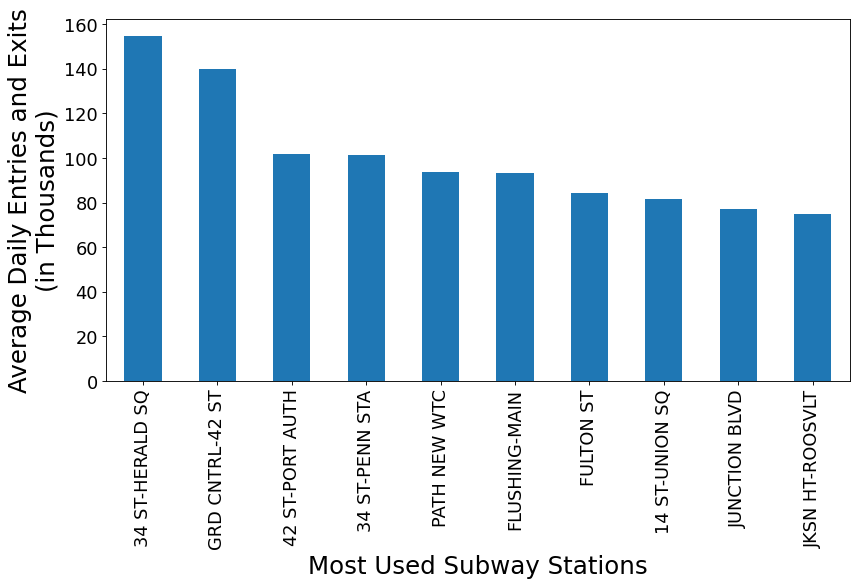

In [42]:
plt.figure(figsize=(12, 6), dpi=80)
station_totals1 = station_totals
station_totals1.ave_daily_entries_and_exits = station_totals1.ave_daily_entries_and_exits/1000
ax =  station_totals1.ave_daily_entries_and_exits.sort_values(ascending=False)[0:10].plot.bar(rot=90)
plt.xlabel("Most Used Subway Stations")
plt.ylabel("Average Daily Entries and Exits" "\n" "(in Thousands)")


In [43]:
taco_mta_pair_df.STATION

1 AV L                                    1 AV
103 ST 6                                103 ST
116 ST 6                                116 ST
125 ST 456                              125 ST
14 ST 123FLM                             14 ST
14 ST-UNION SQ 456LNQRW         14 ST-UNION SQ
145 ST 1                                145 ST
175 ST A                                175 ST
18 ST 1                                  18 ST
18 ST 1                                  18 ST
181 ST 1                                181 ST
207 ST 1                                207 ST
23 ST 1                                  23 ST
23 ST CE                                 23 ST
23 ST FM                                 23 ST
28 ST 1                                  28 ST
28 ST 1                                  28 ST
34 ST-HERALD SQ BDFMNQRW       34 ST-HERALD SQ
34 ST-PENN STA 123              34 ST-PENN STA
34 ST-PENN STA 123              34 ST-PENN STA
34 ST-PENN STA 123              34 ST-PENN STA
34 ST-PENN ST

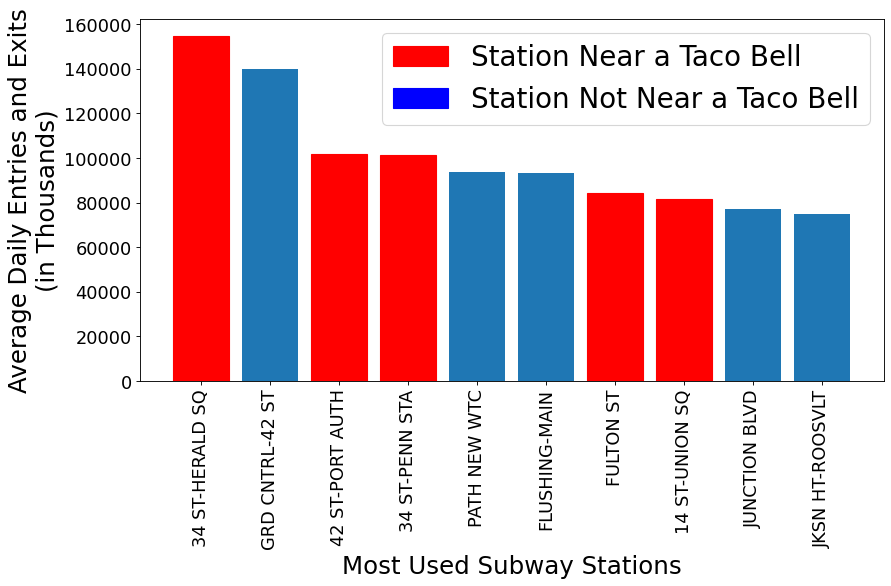

In [44]:
plt.figure(figsize=(12, 6), dpi=80)
station_totals2 = station_totals.sort_values(by = 'ave_daily_entries_and_exits',ascending=False)
station_totals2.ave_daily_entries_and_exits = station_totals2.ave_daily_entries_and_exits*1000
ax =  plt.bar(station_totals2.index[0:10],station_totals2.ave_daily_entries_and_exits[0:10])
ax[0].set_color('r')
ax[2].set_color('r')
ax[3].set_color('r')
ax[6].set_color('r')
ax[7].set_color('r')
plt.xticks(rotation= 90)
plt.xlabel("Most Used Subway Stations")
plt.ylabel("Average Daily Entries and Exits" "\n" "(in Thousands)")
colors = {'Station Near a Taco Bell':'red', 'Station Not Near a Taco Bell':'blue'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)


In [45]:
station_totals.ave_daily_entries_and_exits.sort_values()

STATION
ORCHARD BEACH        0.003066
BROAD CHANNEL        0.336926
181 ST               0.556085
TOMPKINSVILLE        0.583548
BEACH 98 ST          0.860066
                      ...    
PATH NEW WTC        93.629781
34 ST-PENN STA     101.239230
42 ST-PORT AUTH    101.957658
GRD CNTRL-42 ST    140.063901
34 ST-HERALD SQ    154.781068
Name: ave_daily_entries_and_exits, Length: 479, dtype: float64

In [46]:
taco_mta_pair_df.groupby(by = ['Taco_Bell_Address']).Miles.min().mean()

0.11463300080293666

<Figure size 240x480 with 0 Axes>

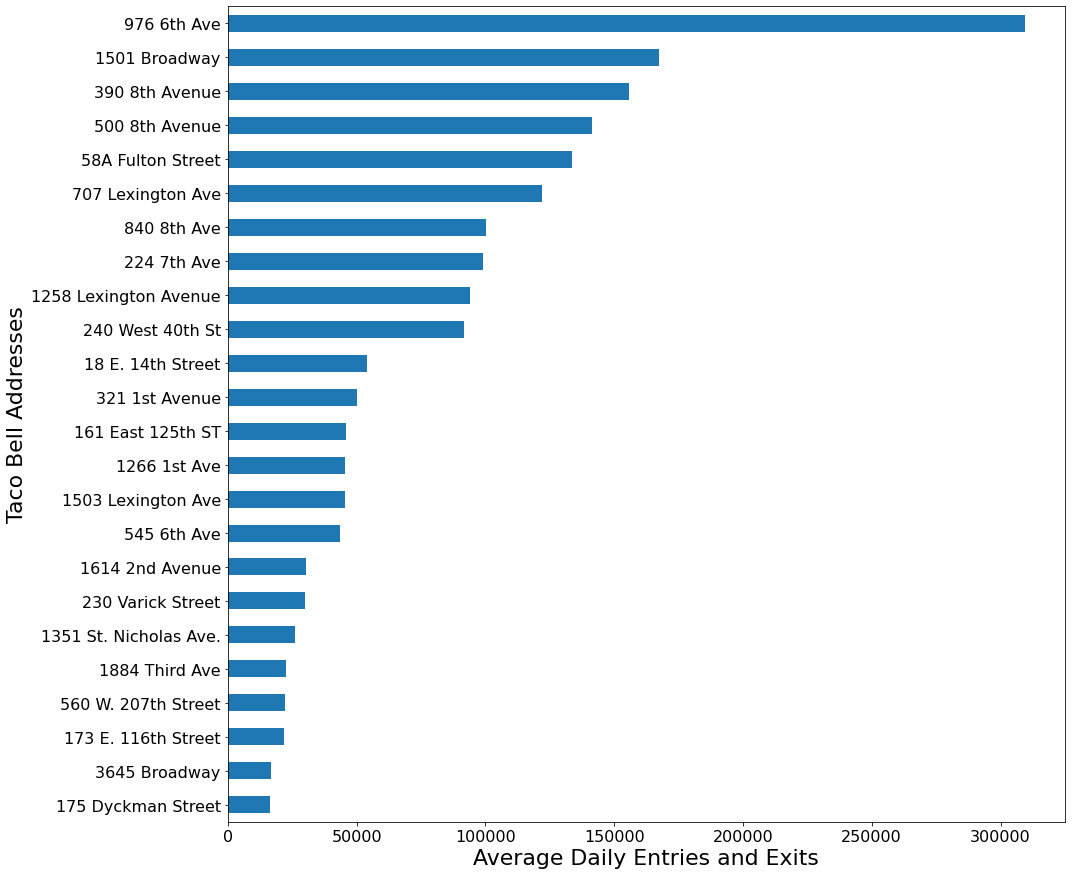

In [47]:
plt.figure(figsize=(3, 6), dpi=80)
taco_bell_foot_traffic_1 = taco_mta_pair_df.groupby(by = ['Taco_Bell_Address']).ave_daily_entries_and_exits.sum().sort_values().to_frame()
taco_bell_foot_traffic = taco_bell_foot_traffic_1.reset_index()
number_of_subways_close_by = taco_mta_pair_df.groupby(by = ['Taco_Bell_Address'])['Station Linename'].count().to_frame()
minimum_distance_from_subway = taco_mta_pair_df.groupby(by = ['Taco_Bell_Address']).Miles.min().sort_values().to_frame()
number_of_subways_close_by = number_of_subways_close_by.join(taco_bell_foot_traffic_1).sort_values(by = ['ave_daily_entries_and_exits'])
number_of_subways_close_by.join(minimum_distance_from_subway)

ax =  number_of_subways_close_by.join(minimum_distance_from_subway).reset_index().plot.barh(x='Taco_Bell_Address', y='ave_daily_entries_and_exits')
plt.xlabel("Average Daily Entries and Exits")
plt.ylabel("Taco Bell Addresses")
ax.get_legend().remove()


In [48]:
taco_bell_foot_traffic.mean()

ave_daily_entries_and_exits    78557.648973
dtype: float64

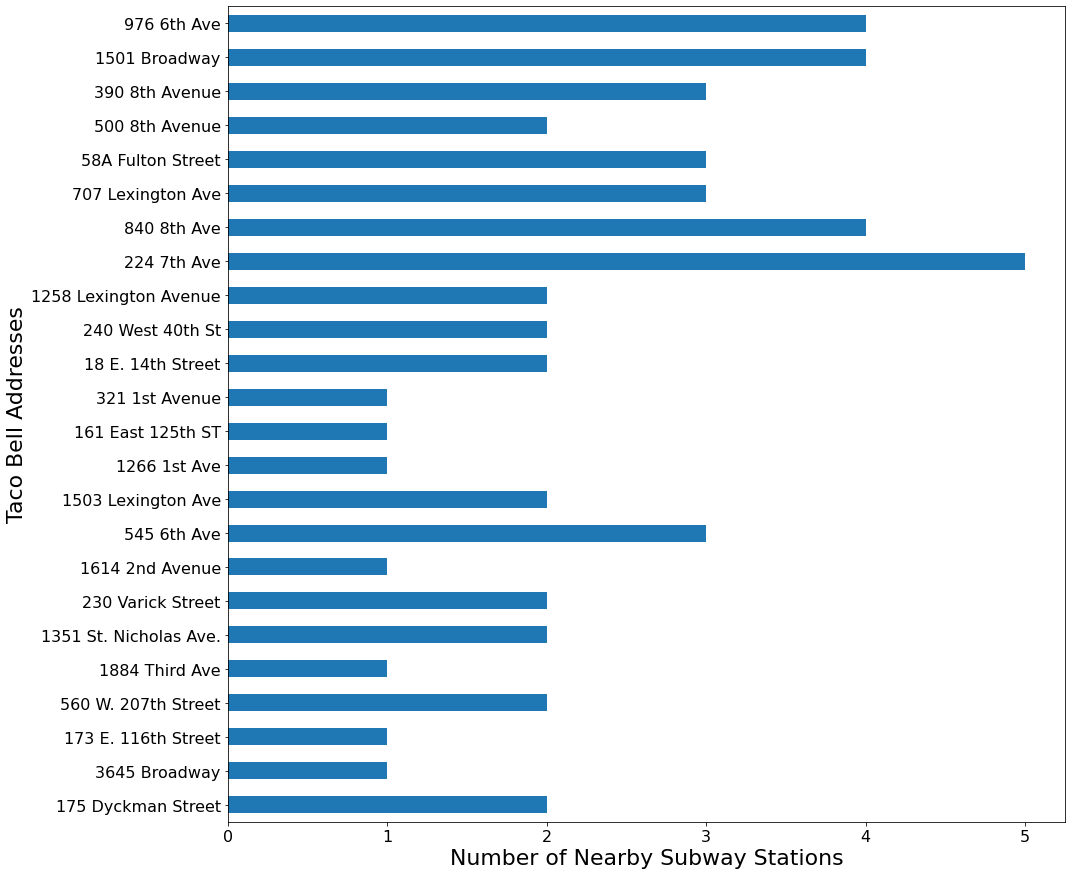

In [49]:
ax =  number_of_subways_close_by.join(minimum_distance_from_subway).reset_index().plot.barh(x='Taco_Bell_Address', y='Station Linename')
plt.xlabel("Number of Nearby Subway Stations")
plt.ylabel("Taco Bell Addresses")
ax.get_legend().remove()


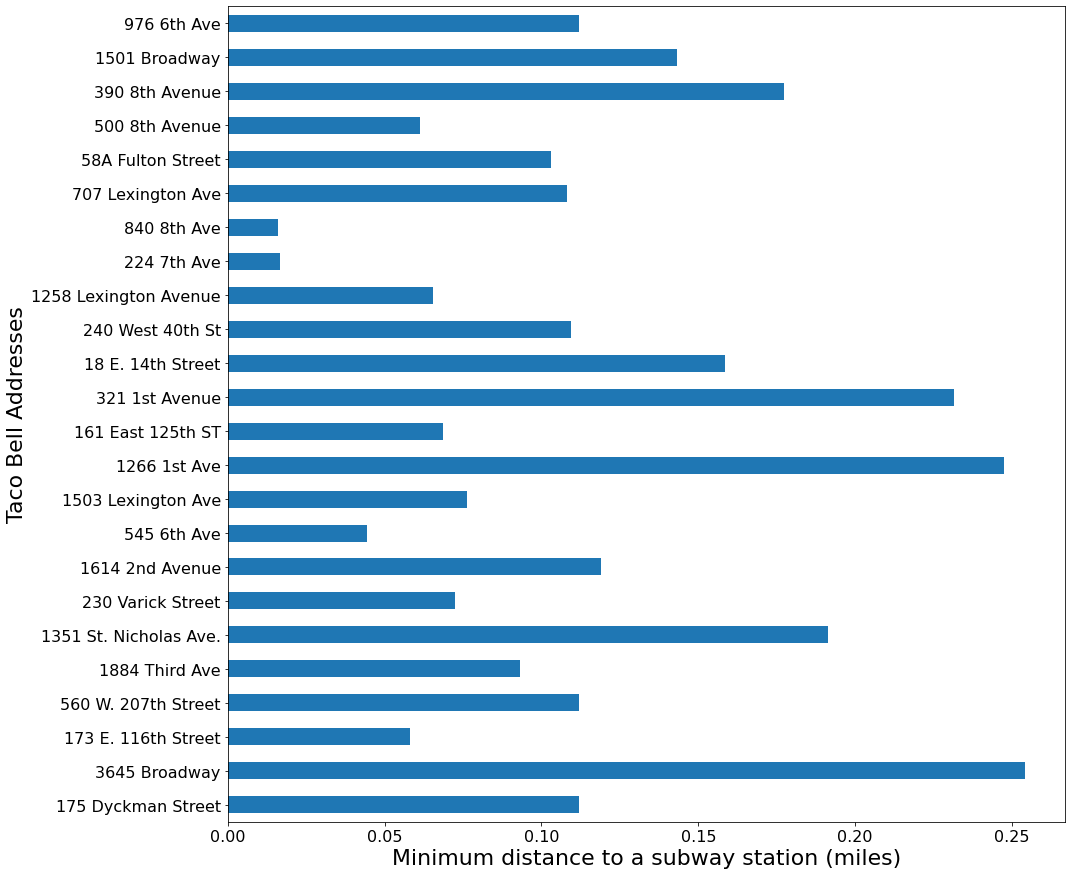

In [50]:
ax =  number_of_subways_close_by.join(minimum_distance_from_subway).reset_index().plot.barh(x='Taco_Bell_Address', y='Miles')
plt.xlabel("Minimum distance to a subway station (miles)")
plt.ylabel("Taco Bell Addresses")
ax.get_legend().remove()


In [51]:
station_totals_ent.head(5)

,STATION_LINENAME,STATION,YEARLY_ENTRIES
0,34 ST-HERALD SQ BDFMNQRW,34 ST-HERALD SQ,24485888.0
1,GRD CNTRL-42 ST 4567S,GRD CNTRL-42 ST,22327112.0
2,PATH NEW WTC 1,PATH NEW WTC,17647359.0
3,42 ST-PORT AUTH ACENQRS1237W,42 ST-PORT AUTH,17643863.0
4,FLUSHING-MAIN 7,FLUSHING-MAIN,16847061.0


### Playing with map

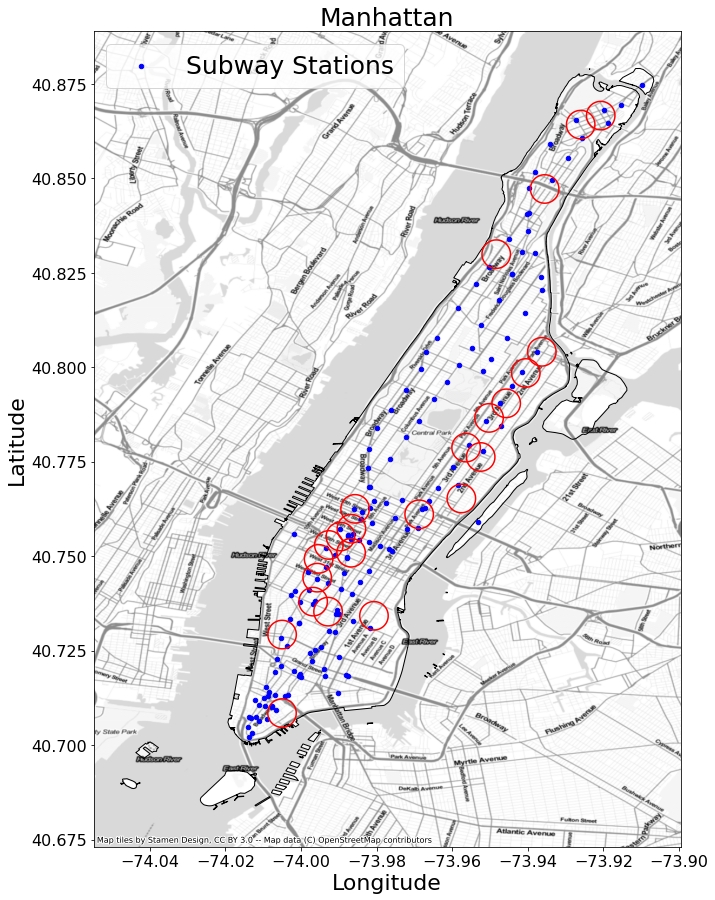

In [52]:
### This figure gives a .25 mile radius around each taco bell
SMALL_SIZE = 16
MEDIUM_SIZE = 22
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
#plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
#plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
#plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


plt.rcParams["figure.figsize"]=15,15

#### Only looking at Manhattan

ax = nybb[nybb.BoroName=='Manhattan'].plot(
   color='None', edgecolor='black')

#### Manhattan MTA
manhattan_MTA.plot(ax = ax,
                   color ='blue',
                   label = 'Subway Stations',
                   alpha = 1,
                   markersize = 20)

#### Manhattan Taco radii
lat_miles_conversion = 1/69
manhattan_taco_orbs = manhattan_tacos.copy()
manhattan_taco_orbs['geometry'] = manhattan_taco_orbs['geometry'].buffer(0.26/69)

#### Manhattan Tacos
manhattan_taco_orbs.plot(ax = ax, 
                         color ='None', 
                         edgecolor = 'red', 
                         linewidth = 1.5, 
                         label = 'Taco Bells', 
                         alpha = 1)

#### This add the background map
cx.add_basemap(ax, crs=nybb.crs,source=cx.providers.Stamen.TonerLite)

#### All of new york
#axx = nybb.plot(color='white', edgecolor='black')

# Plotting Subway Stations:
#geo_MTA_df.plot(ax = axx, color ='blue',label = 'Subway Stations')

# Plotting Taco Bell Data LIVE MAS!
#geo_taco_df.plot(ax = axx, color ='red',label = 'Taco Bells')


plt.legend(loc="upper left")
plt.title("Manhattan")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


In [53]:
manhattan_tacos = manhattan_tacos.set_index('address').join(taco_bell_foot_traffic.set_index('Taco_Bell_Address'))


In [54]:
taco_bell_foot_traffic.head(7)

,Taco_Bell_Address,ave_daily_entries_and_exits
0,175 Dyckman Street,16372.654795
1,3645 Broadway,16653.019178
2,173 E. 116th Street,21717.589041
3,560 W. 207th Street,22361.471233
4,1884 Third Ave,22426.482192
5,1351 St. Nicholas Ave.,26088.810959
6,230 Varick Street,30011.487671


In [55]:
manhattan_tacos.head(7)

,name,city,state,zip,phone,fri_open,fri_close,sat_open,sat_close,sun_open,...,tue_close,wed_open,wed_close,thu_open,thu_close,location,latitude,longitude,geometry,ave_daily_entries_and_exits
address,,,,,,,,,,,,,,,,,,,,,
58A Fulton Street,Taco Bell,New York City,NY,10038,(212) 233-0848,8:00 AM,4:00 AM,8:00 AM,4:00 AM,8:00 AM,...,3:00 AM,8:00 AM,3:00 AM,8:00 AM,4:00 AM,"(58, Fulton Street, Financial District, Manhat...",40.708495,-74.005028,POINT (-74.00503 40.70849),133665.109589
230 Varick Street,Taco Bell,New York City,NY,10014,(646) 823-9315,8:00 AM,3:00 AM,8:00 AM,3:00 AM,8:00 AM,...,2:00 AM,8:00 AM,2:00 AM,8:00 AM,2:00 AM,"(230, Varick Street, West Village, Manhattan C...",40.729263,-74.005006,POINT (-74.00501 40.72926),30011.487671
545 6th Ave,Taco Bell,New York City,NY,10011,(646) 484-9960,8:00 AM,4:30 AM,8:00 AM,4:30 AM,8:00 AM,...,1:30 AM,8:00 AM,1:30 AM,8:00 AM,1:30 AM,"(545, 6th Avenue, Chelsea, Manhattan, New York...",40.737977,-73.996789,POINT (-73.99679 40.73798),43469.580822
224 7th Ave,Taco Bell Cantina,New York City,NY,10011,(518) 531-6144,8:00 AM,4:00 AM,10:00 AM,5:00 AM,8:00 AM,...,4:00 AM,8:00 AM,4:00 AM,8:00 AM,4:00 AM,"(224, 7th Avenue, Chelsea, Manhattan, New York...",40.744320,-73.995716,POINT (-73.99572 40.74432),98888.361644
390 8th Avenue,Taco Bell,New York City,NY,10001,(646) 476-7444,12:00 PM,12:00 AM,12:00 PM,12:00 AM,12:00 PM,...,11:30 PM,12:00 PM,11:30 PM,12:00 PM,11:30 PM,"(390, 8th Avenue, Chelsea, Manhattan, New York...",40.749297,-73.995347,POINT (-73.99535 40.74930),155729.194521
18 E. 14th Street,Taco Bell,New York City,NY,10003,(212) 645-8645,8:00 AM,4:30 AM,8:00 AM,4:30 AM,8:00 AM,...,2:00 AM,8:00 AM,2:00 AM,8:00 AM,4:30 AM,"(Pizza Hut Express, 18, East 14th Street, Unio...",40.735327,-73.992846,POINT (-73.99285 40.73533),53860.126027
500 8th Avenue,Taco Bell Cantina,New York City,NY,10018,(929) 232-3040,8:00 AM,4:00 AM,8:00 AM,5:00 AM,8:00 AM,...,4:00 AM,8:00 AM,4:00 AM,8:00 AM,4:00 AM,"(Taco Bell Cantina, 500, 8th Avenue, Garment D...",40.752968,-73.992643,POINT (-73.99264 40.75297),141409.416438


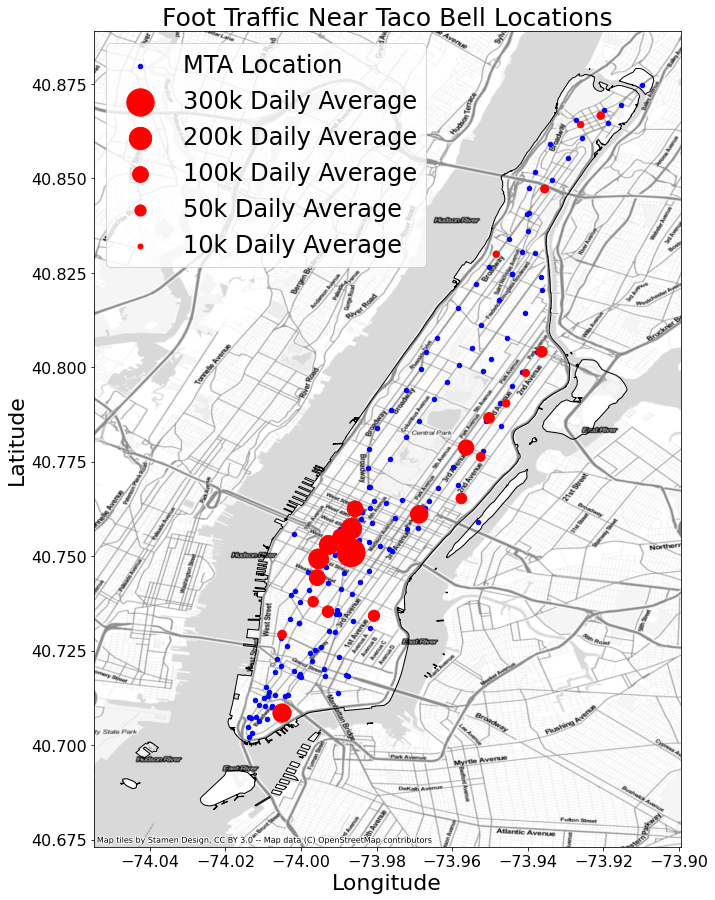

In [56]:
### This figure gives a .25 mile radius around each taco bell

SMALL_SIZE = 16
MEDIUM_SIZE = 22
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
#plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
#plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
#plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


plt.rcParams["figure.figsize"]=15,15

#### Only looking at Manhattan

ax = nybb[nybb.BoroName=='Manhattan'].plot(
   color='None', edgecolor='black')

#### Manhattan MTA
manhattan_MTA.plot(ax = ax,
                   color ='blue',
                   label = 'Subway Stations',
                   alpha = 1,
                   markersize = 20)

#### Manhattan Taco radii
lat_miles_conversion = 1/69
manhattan_taco_orbs = manhattan_tacos.copy()
#manhattan_tacos['geometry'] = manhattan_taco_orbs['geometry'].buffer(manhattan_tacos.ave_daily_entries_and_exits/100000000)

#### Manhattan Tacos
manhattan_tacos.plot(ax = ax, 
                         color ='red', 
                         edgecolor = 'red', 
                         alpha = 1, markersize = manhattan_tacos.ave_daily_entries_and_exits/400)
#### This add the background map
cx.add_basemap(ax, crs=nybb.crs,source=cx.providers.Stamen.TonerLite)

#### All of new york
#axx = nybb.plot(color='white', edgecolor='black')

# Plotting Subway Stations:
#geo_MTA_df.plot(ax = axx, color ='blue',label = 'Subway Stations')

# Plotting Taco Bell Data LIVE MAS!
#geo_taco_df.plot(ax = axx, color ='red',label = 'Taco Bells')
from numpy.random import random
colors = ['b', 'c', 'y', 'm', 'r']
lot = plt.scatter(random(10), random(10), marker='o',s= 20, color='blue')
lo = plt.scatter(random(10), random(10), marker='o',s= 300/.4, color='red')
ll = plt.scatter(random(10), random(10), marker='o',s= 200/.4, color='red')
l  = plt.scatter(random(10), random(10), marker='o',s= 100/.4, color='red')
a  = plt.scatter(random(10), random(10), marker='o',s= 50/.4, color='red')
h  = plt.scatter(random(10), random(10), marker='o',s= 10/.4, color='red')



plt.legend((lot, lo, ll, l, a, h),
           ('MTA Location','300k Daily Average', '200k Daily Average', '100k Daily Average', '50k Daily Average', '10k Daily Average'),
           scatterpoints=1,
           loc='upper left',
           ncol=1,
           fontsize=24)

plt.title("Foot Traffic Near Taco Bell Locations")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


In [57]:
manhattan_tacos.ave_daily_entries_and_exits

address
58A Fulton Street         133665.109589
230 Varick Street          30011.487671
545 6th Ave                43469.580822
224 7th Ave                98888.361644
390 8th Avenue            155729.194521
18 E. 14th Street          53860.126027
500 8th Avenue            141409.416438
240 West 40th St           91783.520548
976 6th Ave               309491.063014
1501 Broadway             167511.898630
840 8th Ave               100052.756164
321 1st Avenue             50228.000000
707 Lexington Ave         122108.920548
1266 1st Ave               45518.739726
1258 Lexington Avenue      94176.849315
1614 2nd Avenue            30469.863014
1503 Lexington Ave         45358.150685
3645 Broadway              16653.019178
1884 Third Ave             22426.482192
173 E. 116th Street        21717.589041
161 East 125th ST          46030.509589
1351 St. Nicholas Ave.     26088.810959
175 Dyckman Street         16372.654795
560 W. 207th Street        22361.471233
Name: ave_daily_entries_and_exit

In [58]:
taco_mta_pair_df

,Taco_Bell_Address,Taco_Latitude,Taco_Longitude,Station_Latitude,Station_Longitude,Miles,Station Linename,STATION,YEARLY_ENTRIES,YEARLY_EXITS,ave_daily_entries,ENTRIES_AND_EXITS,ave_daily_exits,ave_daily_entries_and_exits
1 AV L,321 1st Avenue,40.734234,-73.980700,40.730953,-73.981628,0.231610,1 AV L,1 AV,8891749.0,9441471.0,24360.956164,18333220.0,24360.956164,50228.000000
103 ST 6,1884 Third Ave,40.790440,-73.945717,40.790600,-73.947478,0.093015,103 ST 6,103 ST,3554758.0,4630908.0,9739.063014,8185666.0,9739.063014,22426.482192
116 ST 6,173 E. 116th Street,40.798465,-73.940529,40.798629,-73.941617,0.058149,116 ST 6,116 ST,3921131.0,4005789.0,10742.824658,7926920.0,10742.824658,21717.589041
125 ST 456,161 East 125th ST,40.804069,-73.936287,40.804138,-73.937594,0.068705,125 ST 456,125 ST,6835855.0,9965281.0,18728.369863,16801136.0,18728.369863,46030.509589
14 ST 123FLM,545 6th Ave,40.737977,-73.996789,40.737826,-74.000201,0.179391,14 ST 123FLM,14 ST,4919848.0,4310708.0,13479.035616,9230556.0,13479.035616,25289.194521
14 ST-UNION SQ 456LNQRW,18 E. 14th Street,40.735327,-73.992846,40.734673,-73.989951,0.158529,14 ST-UNION SQ 456LNQRW,14 ST-UNION SQ,6542188.0,10718452.0,17923.802740,17260640.0,17923.802740,47289.424658
145 ST 1,3645 Broadway,40.829904,-73.948354,40.826551,-73.950360,0.254163,145 ST 1,145 ST,2566989.0,3511363.0,7032.846575,6078352.0,7032.846575,16653.019178
175 ST A,1351 St. Nicholas Ave.,40.847155,-73.935535,40.847391,-73.939704,0.219047,175 ST A,175 ST,5628671.0,3690774.0,15421.016438,9319445.0,15421.016438,25532.726027
18 ST 1,545 6th Ave,40.737977,-73.996789,40.741040,-73.997871,0.218877,18 ST 1,18 ST,2761448.0,1476087.0,7565.610959,4237535.0,7565.610959,11609.684932
18 ST 1,224 7th Ave,40.744320,-73.995716,40.741040,-73.997871,0.253016,18 ST 1,18 ST,2761448.0,1476087.0,7565.610959,4237535.0,7565.610959,11609.684932
